# Minimal example

This notebooks reproduces the code-blocks and figures from the *basic usage* page.

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
from vassi.config import cfg
from vassi.io import load_dataset
from vassi.features import DataFrameFeatureExtractor
from vassi.classification.predict import predict
from vassi.classification.visualization import (
    plot_confusion_matrix,
    plot_classification_timeline,
)

from sklearn.ensemble import RandomForestClassifier

In [3]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = ("keypoints", "timestamps")

## 1. Load training dataset and extract features

In [4]:
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)
dataset_train = dataset_train.exclude_individuals(["intruder"])

dataset_train.category_counts

2025-06-17 15:41:06.283 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


{'attack': 14039, 'investigation': 146615, 'mount': 28615, 'none': 318469}

In [5]:
extractor = DataFrameFeatureExtractor(cache_mode=False)
extractor.read_yaml("features-mice.yaml")

len(extractor.feature_names)

201

In [6]:
%%time

X, y = dataset_train.subsample(
    extractor,
    size={category: 1000 for category in dataset_train.categories},
    random_state=1,
)
y = dataset_train.encode(y)

CPU times: user 18.5 s, sys: 420 ms, total: 18.9 s
Wall time: 19.1 s


## 2. Fit classification model

In [7]:
%%time

classifier = RandomForestClassifier(random_state=1)
classifier.fit(X, y)

CPU times: user 5.91 s, sys: 921 μs, total: 5.91 s
Wall time: 5.91 s


RandomForestClassifier(random_state=1)

## 3. Load test dataset and predict

In [8]:
dataset_test = load_dataset(
    "mice_test",
    directory="../../datasets/CALMS21/test",
    target="dyad",
    background_category="none",
)
dataset_test = dataset_test.exclude_individuals(["intruder"])

2025-06-17 15:41:32.419 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [9]:
%%time

result_test = predict(dataset_test, classifier, extractor)

CPU times: user 8.91 s, sys: 35.9 ms, total: 8.95 s
Wall time: 8.95 s


## 4. Visualizations and evaluation

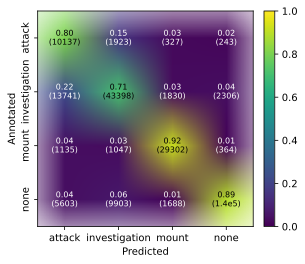

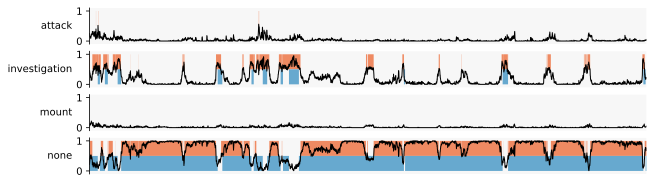

In [10]:
plot_confusion_matrix(
    result_test.y_true_numeric,
    result_test.y_pred_numeric,
    category_labels=result_test.categories,
)

result_group = result_test.classification_results[10]
result_dyad = result_group.classification_results[("resident", "intruder")]

plot_classification_timeline(
    result_dyad.predictions,
    annotations=result_dyad.annotations,
    categories=result_dyad.categories,
    y_proba=result_dyad.y_proba,
    timestamps=result_dyad.timestamps,
)

Compute the F1 score for each category on the per-frame (timestamp) level:

In [11]:
result_test.f1_score("timestamp")

attack           0.468806
investigation    0.738400
mount            0.901669
none             0.932623
Name: timestamp, dtype: float64

This is also available for two other levels, i.e., annotation and prediction intervals.

- when computing scores on prediction intervals, the category of the ground-truth interval with maximum overlap is considered as the true category
- when computing scores on annotation intervals, the category of the predicted interval with maximum overlap is considered as the predicted category

With this in mind, the F1 score of predictions is related to the precision of predicted intervals, whereas the F1 score of annotations is related to the recall of annotated intervals.

In [12]:
result_test.f1_score("annotation")

attack           0.494450
investigation    0.684685
mount            0.822115
none             0.849611
Name: annotation, dtype: float64

In [13]:
result_test.f1_score("prediction")

attack           0.274927
investigation    0.532850
mount            0.480562
none             0.539296
Name: prediction, dtype: float64

And made available as a summary:

interactive-table is a custom tabular data display that we developed for interactive inspection of behavioral classification results. Here, we use it for a better visualization of pandas DataFrames in our documentation.

Important: note that not all interactive fuctions are executed properly without an active python kernel.

In [14]:
from interactive_table import Table

Table(result_test.score())

Table(children=[_TableDisplay(events=['action_click', 'apply_filters', 'on_edit_close', 'on_edit_submit', 'tog…

We later use the unweighted average of all these scores to find optimal postprocessing hyperparameters.

To compare the predictions with the results of other behavioral classification tools using the CALMS21 dataset, we can compute the macro (unweighted average) F1 score of the behavioral foreground categories ('attack', 'investigation' and 'mount'):

In [15]:
foreground_categories = list(dataset_train.foreground_categories)

macro_f1 = result_test.f1_score("timestamp")[foreground_categories].mean()

macro_f1

np.float64(0.702958669540446)

Note that this is only a simple model that was trained on a very small subset of the available data for demonstration purposes.

In [16]:
Table(result_test.predictions)

Table(children=[_TableDisplay(events=['action_click', 'apply_filters', 'on_edit_close', 'on_edit_submit', 'tog…

## 5. Postprocessing (smoothing)

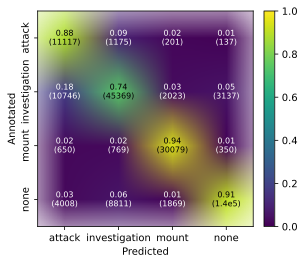

Macro foreground F1 score: 0.702958669540446 -> 0.7506717157154005


In [17]:
from vassi.sliding_metrics import sliding_mean

result_test_smoothed = result_test.smooth(lambda array: sliding_mean(array, window_size=31))

macro_f1_smoothed = (
    result_test_smoothed
    .f1_score("timestamp")[foreground_categories]
    .mean()
)

plot_confusion_matrix(
    result_test_smoothed.y_true_numeric,
    result_test_smoothed.y_pred_numeric,
    category_labels=result_test_smoothed.categories,
)

print("Macro foreground F1 score:", macro_f1, "->", macro_f1_smoothed)

As you can see above, simple smoothing with a sliding mean (window size of ~ one second) can already improve the performance of this basic model.

Note that for simplicity, we here just chose a small window size, but this should be ideally tested or optimized on a part of the training dataset (or using cross validation) and *not* on the test dataset to avoid leakage.

In the comparison below, you can see that this improvement is likely associated with a decrease in very short predictions and frequent back-and-forth between predicted categories. Therefore, smoothing may also reduce temporal resolution or accuracy, so it is advisable to tune such hyperparameters carefully.

before smoothing


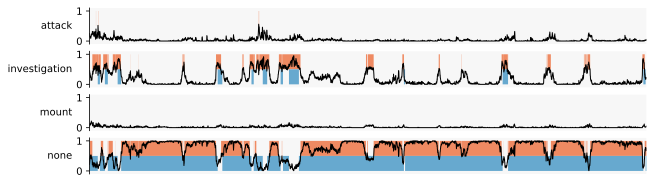

after smoothing


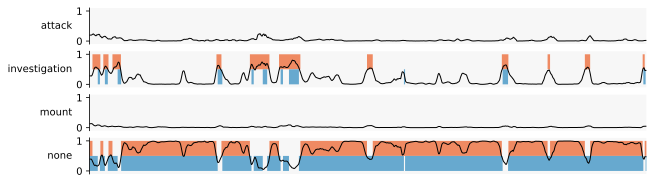

In [18]:
result_dyad_smoothed = result_test_smoothed.classification_results[10].classification_results[("resident", "intruder")]

print("before smoothing")
plot_classification_timeline(
    result_dyad.predictions,
    annotations=result_dyad.annotations,
    categories=result_dyad.categories,
    y_proba=result_dyad.y_proba,
    timestamps=result_dyad.timestamps,
)

print("after smoothing")
plot_classification_timeline(
    result_dyad_smoothed.predictions,
    annotations=result_dyad_smoothed.annotations,
    categories=result_dyad_smoothed.categories,
    y_proba_smoothed=result_dyad_smoothed.y_proba_smoothed,
    timestamps=result_dyad_smoothed.timestamps,
)